# Airline Satisfaction - Classification

The following dataframe was imported from kaggle.com. It presents reviews of a certain airline made by close to 130 thousand people. Each person is identified by his/her ID number follwed by some identifying features of the person and the type of flight and the review of said person in several different categories (explained further down in the notebook). The review system is to give a 0-5 star rating for each category. This is followed by a concluding column of whether the person was overall "satisfied" with the airline and the flight or was "neutral or dissatisfied".<br>
Link to the dataset on kaggle: https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction<br><br>

Our purpose in this notebook is to determine whether a given passenger not from the dataframe given, provided all the data of the passenger's review except the last column where he/she stated the overall satisfaction, was satisfied with the airline or not (in other words: which of the 2 possible answers the passenger would choose: "satisfied" or "neutral or dissatisfied").

In [49]:
#Importing the libraries used
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

We next have to import the dataframe into the notebook. The dataframe was divided on kaggle.com to the train and test set. We shall first combine the 2 dataframes into a single one so as not to apply all changes to both dataframes (to be divided later on in the notebook back into the train and test set, although not necessarily the same ones as on download).<br>
On upload of the .csv files into jupyter as dataframes, an index is added to the dataframes, leaving the initial id as a column of no significance ("Unnamed: 0"). On merging the 2 datasets, again, we give the dataframe a new index, but due to the both columns name being "index" we first rename the index column, then apply the reset_index() function, then drop the column now named "i".<br>
Henceforth, we shall refer to the whole dataset "fulldf" indstead of the train and test sets imported to the notebook (until it is again divided).

In [2]:
defaultTest = pd.read_csv('Datasets/Classification/Import/test.csv') #importing the dataframe 'test.csv' from the appropriate folder
defaultTrain = pd.read_csv('Datasets/Classification/Import/train.csv') #importing the dataframe 'train.csv' from the appropriate folder
fulldf = pd.concat([defaultTest, defaultTrain]) #merging  the 2 datasets, so that we can work as if we were given the undivided
#dataset in the first place.
fulldf.index.name = 'i' #renaming the index column so that the new index will not have the same name as the old
fulldf = fulldf.reset_index() #Resetting the indexes for appearance's sake.
fulldf = fulldf.drop(['i', 'Unnamed: 0'], axis = 1) #removing the columns of indexes which we changed: the change was not
#necessary, only for the sake of appearance
fulldf

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
129876,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
129877,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
129878,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


## Data Cleaning

Before delving into the data cleaning, we first have to understand what it is that we have to do. To do that, we first check whether there are any duplicates in the data provided. Because all reviewer has a unique ID, it is enough to check whether there are 2 reviews (2 records in the dataset) with the same ID. To to that, we group the the dataset by ID using groupby() and check if the size of any of the groups provided is greater than 1 (as we can see below). From this we can gather that no duplicate IDs exist, hence there are no duplicate reviews in the dataset.

In [3]:
dupl = fulldf.groupby(['id']).size()>1
dupl.value_counts()
#Checking that there are no duplicates (no values that are true)

False    129880
dtype: int64

After checking the dataset for duplicates, we no longer need the ID attribute, as it is of little to no use in predicting the overall satisfaction of the reviewer.

In [4]:
fulldf = fulldf.drop(['id'], axis = 1) #Further unneded attribute

Let us first examine the dataset we now have using info(). Here we can see the name of every attribute, the count of non null values for each attribute and the type of data each attribute has. Kepping in mind that the dataset has 129880 records, we can derive that the only attribute that has NaN values is "Arrival Delay in Minutes". We will have to deal with it in a minute. Further on, as seen below, there are several attributes where the type of data is "object". From a quick review of the dataset, we can see that it is a string, which for the purposes of machine learning we shall have to encode as numerical values.

In [5]:
fulldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    1298

In order to encode the attributes with strings we first have to understand what kinds of strings each attribute presents. From the code below we can see that every attribute with strings, has only a small ammount of possible values, for example: the attribute "Gender" has only 2 possible values: "Male" and "Female". All other values for attributes can be seen below, with the amount of values of each value for each attribute.

In [6]:
print('Gender:\n', fulldf['Gender'].value_counts(), '\n')
print('Customer Type:\n', fulldf['Customer Type'].value_counts(), '\n')
print('Type of Travel:\n', fulldf['Type of Travel'].value_counts(), '\n')
print('Class:\n', fulldf['Class'].value_counts(), '\n')
print('satisfaction:\n', fulldf['satisfaction'].value_counts(), '\n')

Gender:
 Female    65899
Male      63981
Name: Gender, dtype: int64 

Customer Type:
 Loyal Customer       106100
disloyal Customer     23780
Name: Customer Type, dtype: int64 

Type of Travel:
 Business travel    89693
Personal Travel    40187
Name: Type of Travel, dtype: int64 

Class:
 Business    62160
Eco         58309
Eco Plus     9411
Name: Class, dtype: int64 

satisfaction:
 neutral or dissatisfied    73452
satisfied                  56428
Name: satisfaction, dtype: int64 



Now that we know what each "object" attribute consists of (in terms of values), we can encode them as we see fit. The most logican encoding (for me at least), is one with integers from 0 onward, where 0 is the "worst" of the options, and going upwards with the nu,bers up to the best, unless it has absolutely no meaning and no "worst" or "best" as is the case with the "Gender" and "Type of Travel" attributes.

In [7]:
#Encoding values from string to numerical

fulldf['Gender'] = fulldf['Gender'].replace({"Male": 0, "Female": 1})
fulldf['satisfaction'] = fulldf['satisfaction'].replace({"neutral or dissatisfied": 0, "satisfied": 1})
fulldf['Type of Travel'] = fulldf['Type of Travel'].replace({"Personal Travel": 0, "Business travel": 1})
fulldf['Customer Type'] = fulldf['Customer Type'].replace({"disloyal Customer": 0, "Loyal Customer": 1})
fulldf['Class'] = fulldf['Class'].replace({"Eco": 0, "Eco Plus": 1, "Business": 2})
fulldf

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,1,52,1,0,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,1
1,1,1,36,1,2,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,1
2,0,0,20,1,0,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,0
3,0,1,44,1,2,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,1
4,1,1,49,1,0,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1,0,23,1,0,192,2,1,2,3,...,2,3,1,4,2,3,2,3,0.0,0
129876,0,1,49,1,2,2347,4,4,4,4,...,5,5,5,5,5,5,4,0,0.0,1
129877,0,0,30,1,2,1995,1,1,1,3,...,4,3,2,4,5,5,4,7,14.0,0
129878,1,0,22,1,0,1000,1,1,1,5,...,1,4,5,1,5,4,1,0,0.0,0


Below are the histogams of every attribute and the with the attribute values as the x axis and the amount of records with said value in said attribute as the y axis. For our purposes, it is of almost no significance, except to visually understand the approximate distributions of values over the dataframe. This is needed in turn to understand that the data is not "capped" on either end (for example), meaning that the actual values were not rounded to a certain value if they were above that value, and likewise below. Another use for the histograms is seing that there are suffficient records for most if not all values of every attribute, for example if all reviewers were men, there will be no point of that attribute for the model's purposes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA63DD6F70>,
      dtype=object)

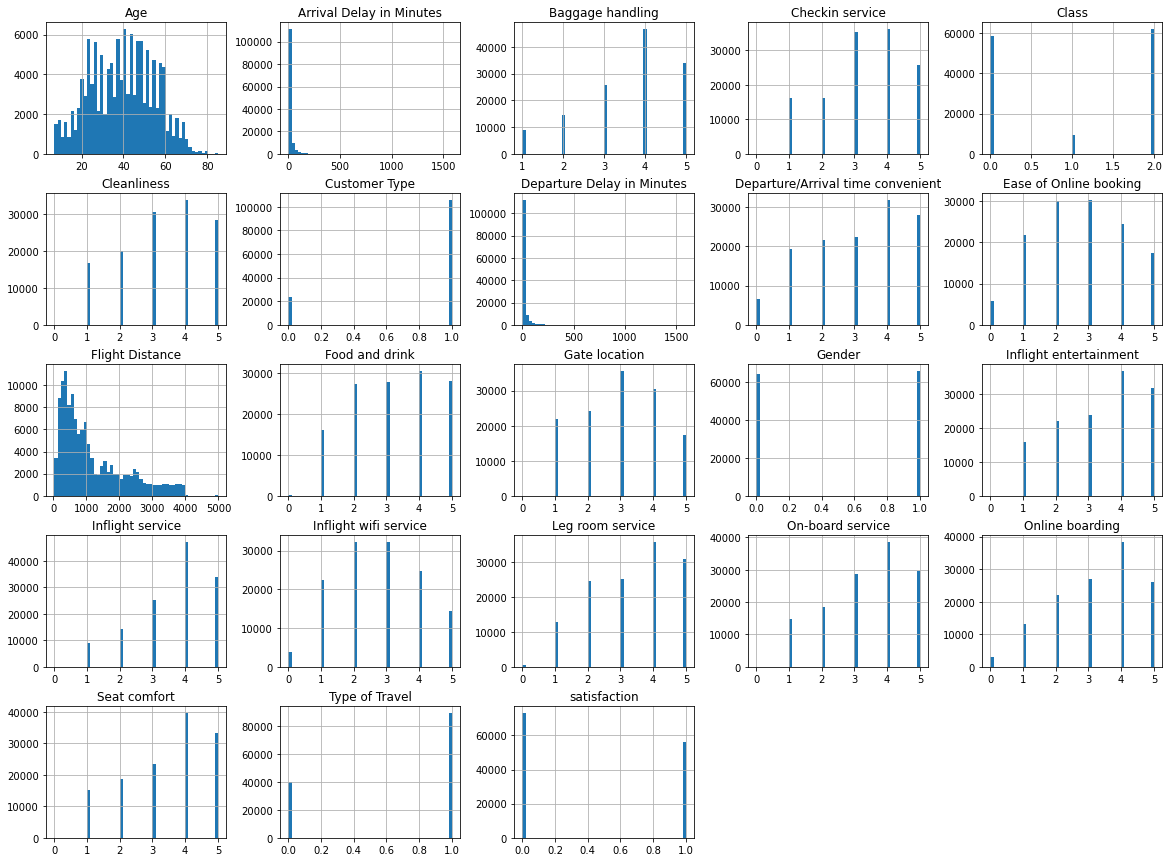

In [8]:
fulldf.hist(bins=50, figsize=(20,15))

### Dealing with NaN values
Below, we list the records which have NaN values in any cell. As we know from before, the only attribute that has NaN values is "Arrival Delay in Minutes", so all the records listed below have the value of said attribute as NaN.

In [9]:
fulldf[fulldf.isna().any(axis=1)]

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
516,1,1,21,0,0,632,1,5,1,4,...,2,4,2,5,4,5,2,9,NaN,0
656,0,1,9,0,0,762,2,5,2,2,...,4,2,5,2,5,2,4,51,NaN,0
1071,0,0,25,1,0,1017,3,4,4,5,...,5,2,5,2,3,2,5,126,NaN,0
1224,0,1,7,0,0,399,4,5,4,4,...,4,4,3,1,1,4,4,0,NaN,0
1589,1,1,58,1,0,129,5,3,3,3,...,5,5,5,5,3,5,5,3,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128043,0,1,49,0,1,1249,2,5,2,3,...,3,4,5,4,3,4,3,230,NaN,0
128360,0,1,58,1,0,733,3,3,3,3,...,3,3,1,2,4,2,3,55,NaN,0
128528,1,0,29,1,0,1107,2,1,1,1,...,5,4,1,5,5,3,5,0,NaN,0
128936,0,1,58,1,0,1088,4,4,1,1,...,5,1,5,5,5,3,5,0,NaN,1


Below we create a dataframe of correlations between every attribute with one another. The dataframe represents the linear correlation between the attributes (non linear relations have very low values as the functions considers only linear relations). The values range between -1 and 1, where positive values represent positive relations ("as X increases, Y increases"), while negative value represent negative relations ("as X increases, Y decreases"). All attribute has an exact linear relation with itself (1.0000). A final thing to not is that the table presented has many duplicates (we could remove the upper right triangle (if the table was cut diagonally from the upper-left corner to the lower-right corner), and not lose any data).

In [10]:
fulldf.corr() # correlation of each attribute with the other

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
Gender,1.000000,-0.030958,-0.008996,0.009503,-0.005774,-0.003616,-0.005901,-0.008995,-0.005893,0.000863,...,-0.003843,-0.006447,-0.031047,-0.036356,-0.008462,-0.038504,-0.002867,-0.003491,-0.001309,-0.011236
Customer Type,-0.030958,1.000000,0.284172,-0.308236,0.105641,0.226021,0.005757,0.206873,0.018059,-0.004465,...,0.106001,0.054172,0.046841,-0.024874,0.031243,-0.023292,0.081302,-0.003859,-0.004730,0.186017
Age,-0.008996,0.284172,1.000000,0.044808,0.140504,0.099459,0.016116,0.036960,0.022565,-0.000398,...,0.074947,0.057078,0.039119,-0.047991,0.033475,-0.051347,0.052565,-0.009041,-0.011248,0.134091
Type of Travel,0.009503,-0.308236,0.044808,1.000000,0.545447,0.266792,0.105865,-0.257102,0.134078,0.029869,...,0.152936,0.059794,0.139612,0.033012,-0.016247,0.023538,0.084615,0.005913,0.005830,0.449861
Class,-0.005774,0.105641,0.140504,0.545447,1.000000,0.450814,0.036869,-0.089976,0.107537,0.005861,...,0.196246,0.211103,0.206129,0.161364,0.151299,0.155864,0.138491,-0.009877,-0.014104,0.492947
Flight Distance,-0.003616,0.226021,0.099459,0.266792,0.450814,1.000000,0.006701,-0.018914,0.065165,0.005520,...,0.130507,0.111194,0.134533,0.064855,0.073608,0.059316,0.095648,0.002402,-0.001935,0.298085
Inflight wifi service,-0.005901,0.005757,0.016116,0.105865,0.036869,0.006701,1.000000,0.344915,0.714807,0.338573,...,0.207802,0.119928,0.160317,0.120376,0.043762,0.110029,0.131300,-0.015946,-0.017749,0.283460
Departure/Arrival time convenient,-0.008995,0.206873,0.036960,-0.257102,-0.089976,-0.018914,0.344915,1.000000,0.437620,0.447510,...,-0.008380,0.067297,0.010617,0.070833,0.091132,0.072195,0.009862,0.000778,-0.000942,-0.054270
Ease of Online booking,-0.005893,0.018059,0.022565,0.134078,0.107537,0.065165,0.714807,0.437620,1.000000,0.460041,...,0.046564,0.039064,0.109450,0.039148,0.008819,0.035373,0.015125,-0.005318,-0.007033,0.168877
Gate location,0.000863,-0.004465,-0.000398,0.029869,0.005861,0.005520,0.338573,0.447510,0.460041,1.000000,...,0.002741,-0.029019,-0.005181,0.000972,-0.039353,0.000310,-0.005918,0.005973,0.005658,-0.002793


We can see from the correlation function above that the attributes "Arrival Delay in Minutes" and "Departure Delay in Minutes" have an extremely high linear correlation (0.9653), and, although not an exact duplicate, as we have NaN values for of the "Arrival Delay in Minutes" and not of "Departure Delay in Minutes", we can copy values from the later to the former, where needed. Again, it is not a perfect match, nor do we expect the values copied to be an exact replica of what happened in reality, but I believe it is close enough to the truth to be accepted. All that remains, after making the decision, is to make said changes, which is done below.

In [11]:
fulldf['Arrival Delay in Minutes'].fillna(fulldf['Departure Delay in Minutes'], inplace = True)

Next, due to the 2 attributes having so close a relation (as mentioned in the cell above), we can remove the unneeded attribute. We define which of the 2 is unneded by checking which has a slightly closer linear relation to the overall satisfaction.

In [12]:
fulldf = fulldf.drop(['Departure Delay in Minutes'], axis = 1) #removing the departure delay in minutes -
#correlation is 0.96 - very high, no need for both as one follows mostly from the other

In [13]:
fulldf.info() #Presenting the final dataset info before maachine learning algorithms for future reference

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  int64  
 1   Customer Type                      129880 non-null  int64  
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  int64  
 4   Class                              129880 non-null  int64  
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    1298

One last thing we have to do before we split the data into train and test sets, we have to normalize the values. As all are values are now numerical, and there are no NaN values, we can do that without too much trouble. The normalization will only be done on the values which will be given to us in the future for prediction (all data except the attribute which we have decided to predict: the overall satisfaction of the reviewer). In this case, the overall satisfaction is already normalized as it comprises of values 0 and 1 only, but in general it is not necessary to normalize the attribute for prediction.<br>
We choose normalizaiton and not standartization due to there being no outliers in this dataset.<br><br>
To normalize the data, we first split it to x and y, and mentioned above.

In [14]:
x = fulldf.drop(['satisfaction'], axis = 1)
y = fulldf['satisfaction']

Next, we use the fuction min_max_scaler.fit_transform() method to achive normalization of the data.

In [15]:
z = x.values #returns a numpy array
min_max_scaler = MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(z)
x = pd.DataFrame(z_scaled)
x

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.0,1.0,0.576923,1.0,0.0,0.026050,1.0,0.8,0.6,0.8,...,0.8,0.6,1.0,1.0,1.0,1.00,0.4,1.0,1.0,0.027778
1,1.0,1.0,0.371795,1.0,1.0,0.571890,0.2,0.2,0.6,0.2,...,0.8,1.0,0.8,0.8,0.8,0.75,0.6,0.8,1.0,0.000000
2,0.0,0.0,0.166667,1.0,0.0,0.032512,0.4,0.0,0.4,0.8,...,0.4,0.4,0.4,0.8,0.2,0.50,0.4,0.4,0.4,0.000000
3,0.0,1.0,0.474359,1.0,1.0,0.675687,0.0,0.0,0.0,0.4,...,0.8,0.8,0.2,0.2,0.2,0.00,0.6,0.2,0.8,0.003788
4,1.0,1.0,0.538462,1.0,0.0,0.232431,0.4,0.6,0.8,0.6,...,0.2,0.4,0.4,0.4,0.4,0.25,0.8,0.4,0.8,0.012626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1.0,0.0,0.205128,1.0,0.0,0.032512,0.4,0.2,0.4,0.6,...,0.4,0.4,0.4,0.6,0.2,0.75,0.4,0.6,0.4,0.000000
129876,0.0,1.0,0.538462,1.0,1.0,0.467690,0.8,0.8,0.8,0.8,...,0.8,1.0,1.0,1.0,1.0,1.00,1.0,1.0,0.8,0.000000
129877,0.0,0.0,0.294872,1.0,1.0,0.396607,0.2,0.2,0.2,0.6,...,0.2,1.0,0.8,0.6,0.4,0.75,1.0,1.0,0.8,0.008838
129878,1.0,0.0,0.192308,1.0,0.0,0.195679,0.2,0.2,0.2,1.0,...,0.2,0.2,0.2,0.8,1.0,0.00,1.0,0.8,0.2,0.000000


## Models
Now that we are finished with data cleaning, we have a dataset, where there are no NaN values, all attributes are numerical and normalized, we can split the data using the train_test_split() method. The method splits the data according to a random state (an integer), so that over multiple reruns, the resulting dataframes from the method remain the same. The test size is set to 0.1 (10%), which results in close to 13000 records (which is enough in my opinion).

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

Now that we have split our data, we can get down to the models. Before choosing and applying the models to the data, we need a baseline model, to compare all others to it: if the models thereafter are worse than the base model, we are doing something wrong. If the model is better than the base model, on the other hand, it means that the model works, and is able to be better at predicting than a "dummy" model. The base model we will use is "Dummy Classifier", which will, regardless of the input, put in the most frequent value in y_train. It puts in the most frequent value due to the strategy we have put into the model, although we could choose differently, but this strategy seems to return the best results.<br><br>
after using the model.fit() and model.predict() methods, we can use the metrics.accuracy_score() method to test a see which percentage of the predictions made by the dummy classifier were correct. in our case, the percentage of correct answers is 56.7%. Not bad, although not unexpected, as it almost certainly would have to be over 50%, as out of the 2 options, the dummy classifier chose the one which appeared the most.

In [17]:
dummyModel = DummyClassifier(strategy="most_frequent")
dummyModel.fit(X_train, y_train)
predictionsDummy = dummyModel.predict(X_test)

metrics.accuracy_score(y_test, predictionsDummy)

0.5637511549122267

Now that we know what we strive for (a model that returns an accurace of more than 0.56), we can start applying a model to the daa that does something more than the dummy classifier. We will first use the KNN model. The KNN model (K nearest Neighbors) is one that chooses the value closest to the values from the train set. if K = 1, then it chooses depending on the single closest neighbor to the wanted data; if N > 1, then it chooses the label depending on the N closest neighbors (in terms of data). The "weights" parameter specifies whether the model is to give a higher penalty for the neighbors further away or to count their value as equally valuable to determine the label.<br><br>
In the cell below we run a function, which purpose is to determine the best N value, meaning the number of neighbors for which the data works best. True, the differences seem not very signufucant between the different values, but I believe it gives perspective.<br>
*Note: Due to the function run time being abysmal (several minutes), we will save the results in a different variable, and put the function call as a comment, so as not to delay the running of the notebook.

In [29]:
def chooseKNN():
    maxi = 1 #saving the index of the highest score
    max = 0 #saving the value of the highest score
    for i in range(1,20):
        modelKNN = KNeighborsClassifier(n_neighbors = i, weights='distance')
        modelKNN.fit(X_train, y_train)
        accuracy = modelKNN.score(X_test, y_test)
        if (accuracy > max):
            maxi = i
            max = accuracy
    print(maxi, "  ", max)
#chooseKNN()
#The value for maxi returned was: 9
#The value for max was: 0.9335540498922081

We have identified the best amount of neightbors for this data: 9. We shall run the model one last time to record the predictions made, co calculate the models accuracy using measures other than the built in score() method.

In [31]:
modelKNN = KNeighborsClassifier(n_neighbors = 9, weights='distance')
modelKNN.fit(X_train, y_train)
predictionsKNN = modelKNN.predict(X_test)
metrics.accuracy_score(y_test, predictionsKNN) #Resturns the same value as the score() method in the previous cell

0.9335540498922081

# To show as graph

In [32]:
acc = y_test == predictions
acc.value_counts()

True     12125
False      863
Name: satisfaction, dtype: int64

Below we calculate the best cv parameter (K-folds) value for the cross validation score. We run from 1 to 20. The cv value in cross validation score means the number of "folds" the training set is divided into.<br>
Cross validation is when we divide the training set into a certain number of parts of identical length. There are made this certain anount of runs, when for each run, a different one of the divided sets is set aside. The model runs as in the usual trainig set, then another "piece" of the training set is used. Their performances are recorded, and the mean value is displayed.<br><br>
We have identified after these runs that 19 is the best number of k-folds for this data (out of the given range at least). As we were hoping, the r2 score matches (almost) the r2 score of the original model, meaning the model works as expected, without overfitting or underfitting (most probably).<br>
*Note: As with KNN value, due to the function run time being abysmal (several minutes), we will save the results in a different variable, and put the function call as a comment, so as not to delay the running of the notebook.

In [42]:
def chooseKFold(model):
    maxi = 1 #saving the index of the highest score
    max = 0 #saving the value of the highest score
    for i in range(2,20):
        accuracy = cross_val_score(model, X_train, y_train, cv = i).mean()
        if (accuracy > max):
            maxi = i
            max = accuracy
    print('Best index:', maxi, "\ncross_val_score of index", maxi, ':', max)

In [35]:
#chooseKFold(modelKNN)
#The value for maxi returned was: 19
#The value for max was: 0.9317832165238031

19    0.9317832165238031


We now want to know exactly how well our model has performed on the task at hand. We shall plot a confusion matrix to understand how many of the answers the model got wrong and right per label for the test set.<br>
Each cell from left to right and top to bottom: The model said 0 and it was 0, the model said 1 and it was 0, the model said 1 and it was 0, the model said 1 and it was 1.<br>
This is of course, where 0 is "newtral or dissatisfied" and 1 is "satisfied".<br>
In other words, the diagonal cells from top left corner are the value the model predicted correctly, all others (in this case only 2), are the ones thee model predicted incorrectly.<br><br>
Next, we want to show the "classification report" of the model at hand (KNN).

In [52]:
print(confusion_matrix(y_test, predictionsKNN))
print(classification_report(y_test, predictionsKNN))

[[7103  219]
 [ 644 5022]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7322
           1       0.96      0.89      0.92      5666

    accuracy                           0.93     12988
   macro avg       0.94      0.93      0.93     12988
weighted avg       0.93      0.93      0.93     12988



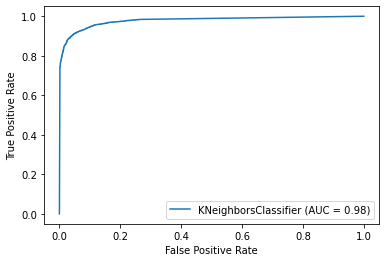

In [22]:
metrics.plot_roc_curve(modelKNN, X_test, y_test)

In [40]:
from sklearn.linear_model import LogisticRegression
modelLogReg = LogisticRegression()
modelLogReg.fit(X_train, y_train)
predictionsLogReg = modelLogReg.predict(X_test)
accuracy = modelLogReg.score(X_test, y_test)
accuracy

0.8728826609177702

Below, again, the function for identifying the optimal k-fold was run. As is clearly visible, the result is very similar to the original model of Logistic Regression, meaning the model works as should, without overfitting or underfitting (most probably)

In [43]:
chooseKFold(modelLogReg)

12    0.8742771104951578


In [53]:
print(confusion_matrix(y_test, predictionsLogReg))
print(classification_report(y_test, predictionsLogReg))

[[6601  721]
 [ 930 4736]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      7322
           1       0.87      0.84      0.85      5666

    accuracy                           0.87     12988
   macro avg       0.87      0.87      0.87     12988
weighted avg       0.87      0.87      0.87     12988



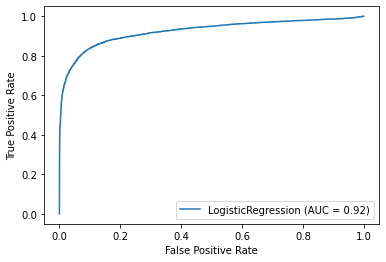

In [47]:
metrics.plot_roc_curve(modelLogReg, X_test, y_test)